In [1]:
import sys
sys.path.insert(0, './..')
sys.path.insert(0, '../data')

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import proplot as pplt
import numpy as np
import plots as pl
import tqdm
from models import model
import torch
from torchvision import datasets, transforms
from robustness.datasets import CIFAR
import dill
import pickle5 as pickle
from utils import dev, load_data, classification, make_orth_basis, orth_check

from models import eval
from matplotlib.ticker import FormatStrFormatter
import tqdm
from scipy.stats import kstest, multivariate_normal
import seaborn as sns


# Load models

### MNIST

In [1]:
# load models
model_natural = model.madry_diff()
model_robust = model.madry_diff()
model_natural.load_state_dict(torch.load('../models/natural_2.pt', map_location=torch.device(dev())))
model_robust.load_state_dict(torch.load('../models/robust_2.pt', map_location=torch.device(dev())))
model_natural.to(dev())
model_robust.to(dev())
model_natural.eval()
model_robust.eval()

NameError: name 'model' is not defined

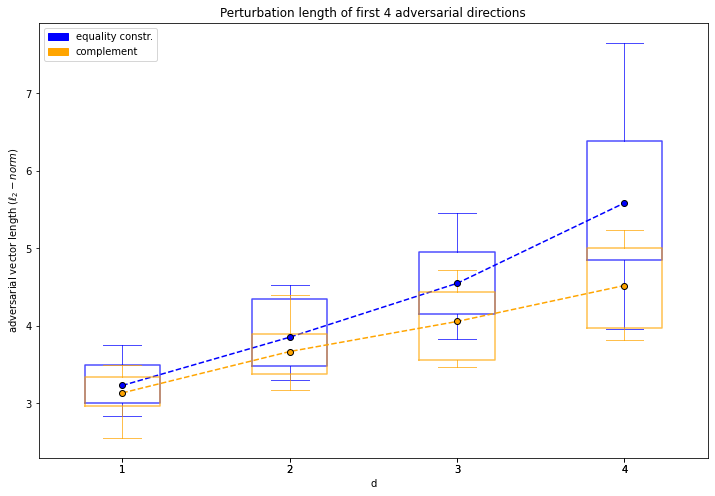

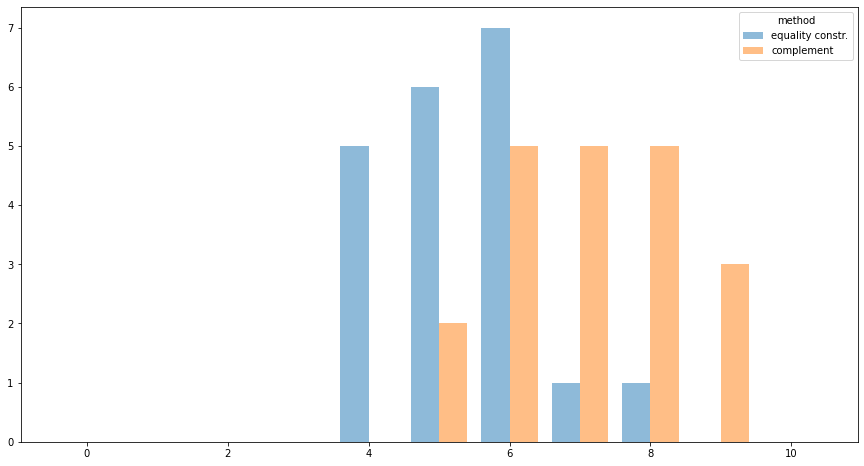

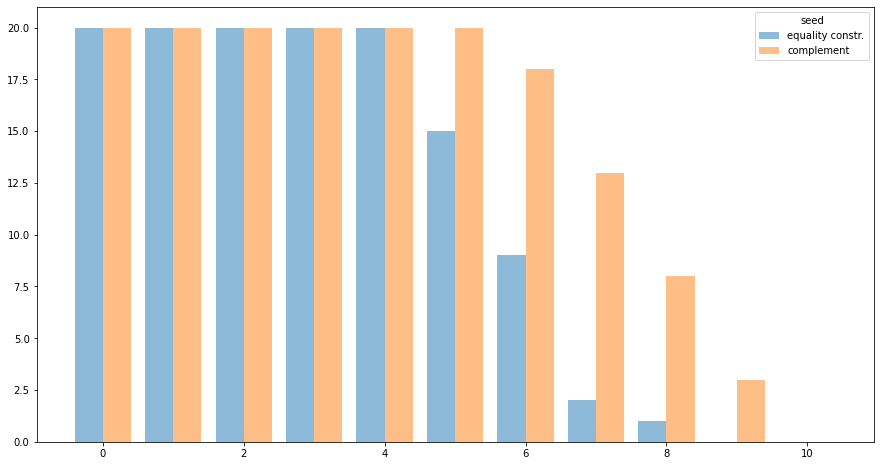

In [35]:
data = np.load('../data/robust0_0.npy', allow_pickle=True).item()
images = data['images']
labels = data['labels']
n_advs = np.zeros((2,len(images)))
pert_lengths = data['pert_lengths']
pert_lengths[pert_lengths==0] = np.nan
sort_idx = np.argsort(pert_lengths,axis=-1)
for i, idx in enumerate(sort_idx):
    pert_lengths[i] = pert_lengths[i,idx]
n_advs[0] = np.invert(np.isnan(pert_lengths)).sum(1)

# load data
data = np.load('../data/robust_complement_0_4.npy', allow_pickle=True).item()
pert_lengths_c = data['pert_lengths']

for i in range(9):
    data = np.load('../data/robust_complement_0_'+str(i+1)+'.npy', allow_pickle=True).item()
    pert_lengths_c = np.concatenate((pert_lengths_c, data['pert_lengths']),axis=0)
    
pert_lengths_c[pert_lengths_c==0] = np.nan
sort_idx = np.argsort(pert_lengths_c,axis=-1)
for i, idx in enumerate(sort_idx):
    pert_lengths_c[i] = pert_lengths_c[i,idx]
    
# plot with all adversarials included
n=4

p_robust = pert_lengths_c[np.invert(np.isnan(pert_lengths_c)).sum(-1)>=n]
p_natural = pert_lengths[np.invert(np.isnan(pert_lengths)).sum(-1)>=n]

fig , ax = pl.plot_pert_lengths([p_natural,p_robust],  n=n, labels=['equality constr.','complement'], ord=2)
fig.set_figheight(8)
fig.set_figwidth(12)
plt.show()
n_advs[1] = np.invert(np.isnan(pert_lengths_c)).sum(1)

n_bins=11
plt.figure(figsize=(15,8))
plt.hist(n_advs.T, alpha=0.5, bins=n_bins, range=(-0.5,n_bins-0.5), label=['equality constr.','complement'])
plt.legend(title='method')
plt.show()

plt.figure(figsize=(15,8))
plt.hist(n_advs.T, alpha=0.5, bins=n_bins, range=(-0.5,n_bins-0.5), cumulative=-1, label=['equality constr.','complement'])
plt.legend(title='seed')
plt.show()

# np.mean(np.std(n_advs,axis=0))

## CIFAR

In [4]:
ds = CIFAR('../data/cifar-10-batches-py')
classifier_model = ds.get_model('resnet50', False)
model_natural = model.cifar_pretrained(classifier_model, ds)

resume_path = '../models/cifar_nat.pt'
checkpoint = torch.load(resume_path, pickle_module=dill, map_location=torch.device(dev()))

state_dict_path = 'model'
if not ('model' in checkpoint):
    state_dict_path = 'state_dict'
sd = checkpoint[state_dict_path]
sd = {k[len('module.'):]:v for k,v in sd.items()}
model_natural.load_state_dict(sd)
model_natural.to(dev())
model_natural.double()
model_natural.eval()

classifier_model = ds.get_model('resnet50', False)
model_robust = model.cifar_pretrained(classifier_model, ds)

resume_path = '../models/cifar_l2_0_5.pt'
checkpoint = torch.load(resume_path, pickle_module=dill, map_location=torch.device(dev()))

state_dict_path = 'model'
if not ('model' in checkpoint):
    state_dict_path = 'state_dict'
sd = checkpoint[state_dict_path]
sd = {k[len('module.'):]:v for k,v in sd.items()}
model_robust.load_state_dict(sd)
model_robust.to(dev())
model_robust.double()
model_robust.eval()

cifar_pretrained(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): SequentialWithArgs(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05,

In [5]:
# load data
data_nat = np.load('../data/cifar_natural.npy', allow_pickle=True).item()
advs = data_nat['advs']
pert_lengths = data_nat['pert_lengths']
classes = data_nat['adv_class']
dirs = data_nat['dirs']
images = data_nat['images']
labels = data_nat['labels']
pert_lengths = data_nat['pert_lengths']

data_madry = np.load('../data/cifar_robust.npy', allow_pickle=True).item()
images_madry = data_nat['images']
labels_madry = data_nat['labels']
advs_madry = data_madry['advs']
pert_lengths_madry = data_madry['pert_lengths']
classes_madry = data_madry['adv_class']
dirs_madry = data_madry['dirs']

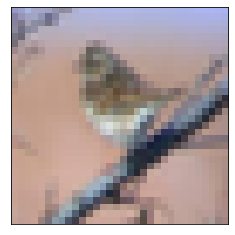

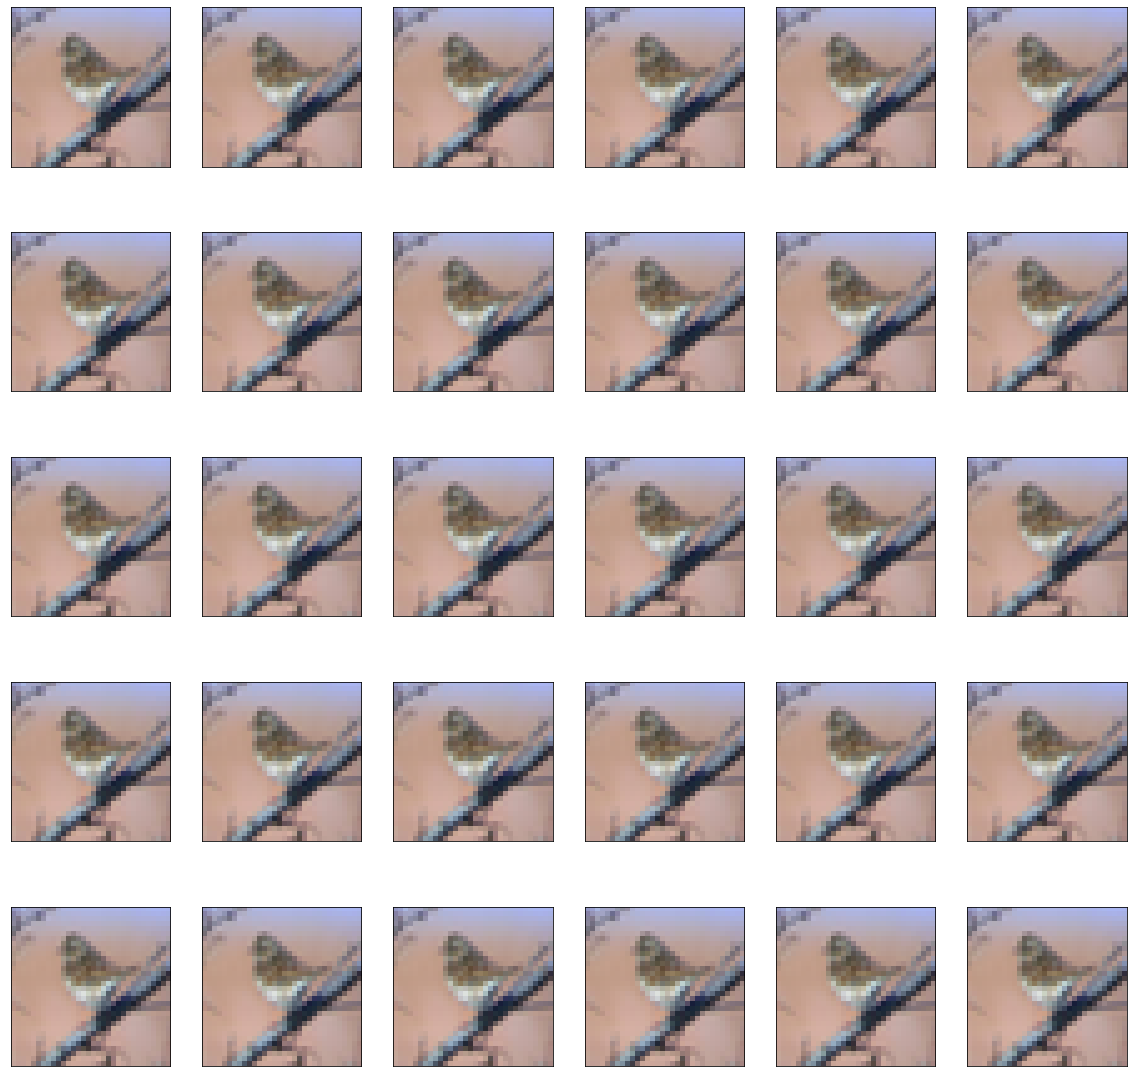

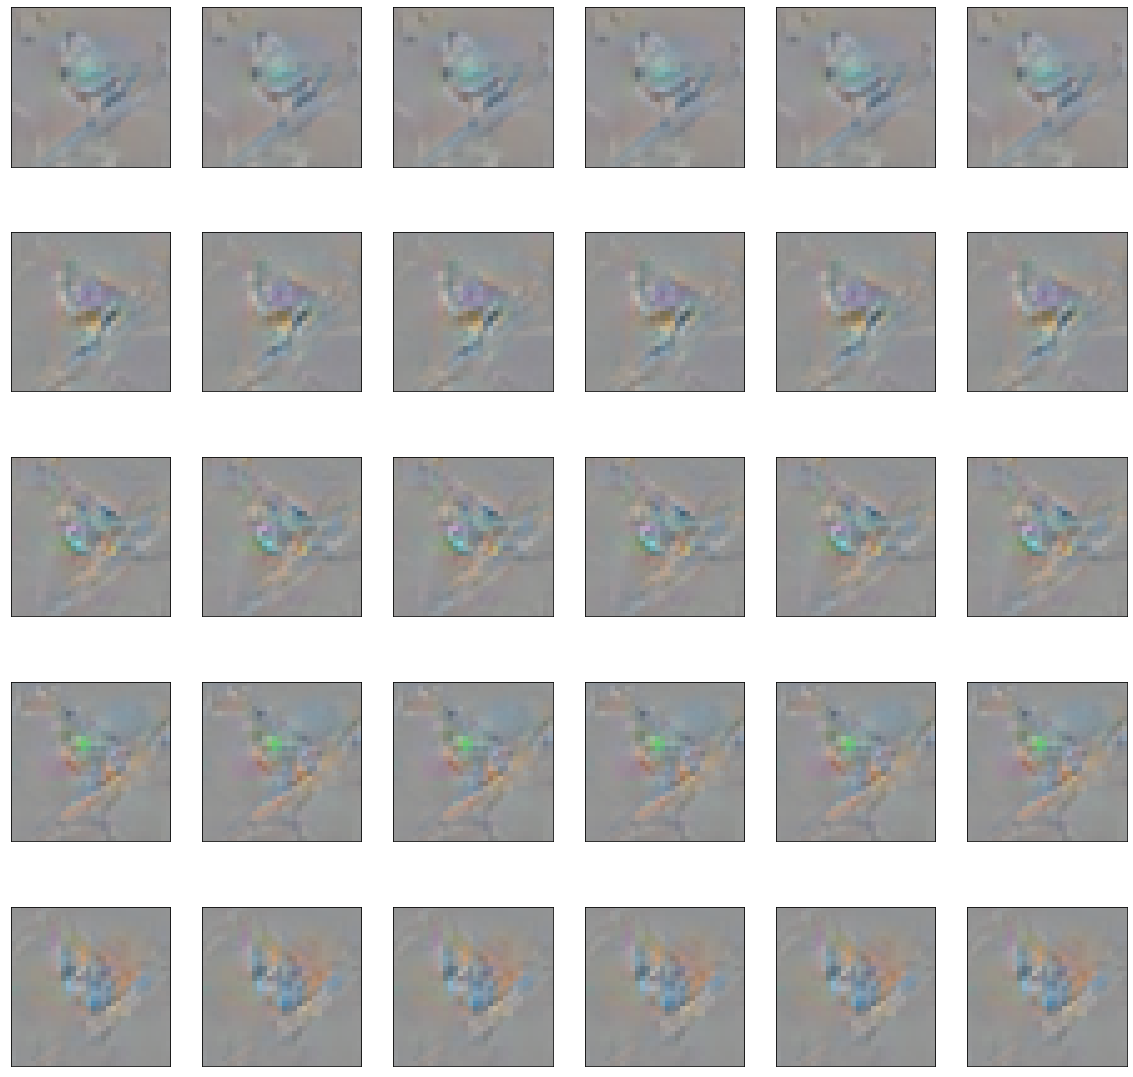

In [201]:
img_n = 28
plt.imshow(np.transpose(images_madry[img_n].reshape((3,32,32)), (1,2,0)))
plt.xticks([])
plt.yticks([])

fig, ax = plt.subplots(5,6, figsize=(20,20))
for i in range(5):
    for j in range(6):
        ax[i,j].imshow(np.transpose(advs_madry[img_n,i].reshape((3,32,32)), (1,2,0)))
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    
fig, ax = plt.subplots(5,6, figsize=(20,20))
min_ = dirs_madry[img_n].min()
max_ = dirs_madry[img_n].max()

dirs_ = (dirs_madry[img_n]-min_)/(max_-min_)
for i in range(5):
    for j in range(6):
        ax[i,j].imshow(np.transpose(dirs_[i].reshape((3,32,32)), (1,2,0)))
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

# Check seed consistency

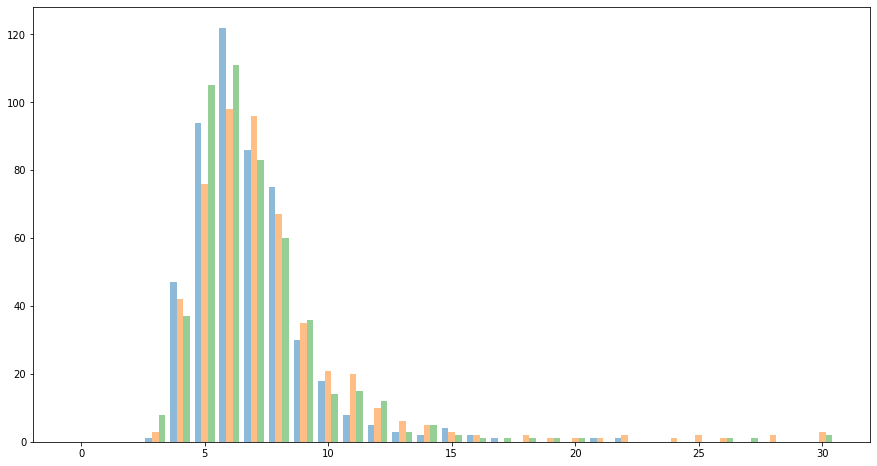

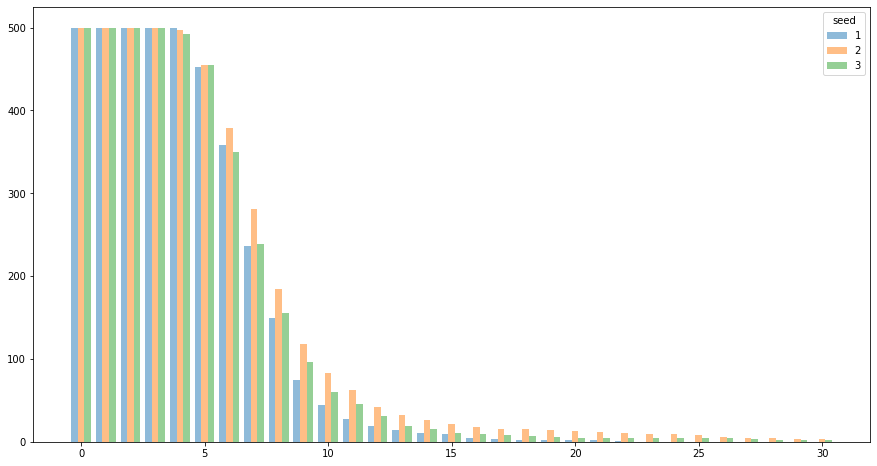

0.9431447900647579

In [14]:
data = np.load('../data/robust_0.npy', allow_pickle=True).item()
images = data['images']
labels = data['labels']
n_advs = np.zeros((3,len(images)))
for i,model_id in enumerate([0,1,2]):
    # load data
    data = np.load('../data/robust_'+str(model_id)+'.npy', allow_pickle=True).item()
    advs = data['advs']
    pert_lengths = data['pert_lengths']
    classes = data['adv_class']
    dirs = data['dirs']
    images = data['images']
    labels = data['labels']
    pert_lengths = data['pert_lengths']
    n_advs[i] = np.invert(np.isnan(pert_lengths)).sum(1)
plt.figure(figsize=(15,8))
plt.hist(n_advs.T, alpha=0.5, bins=31, range=(-0.5,30.5))
plt.show()

plt.figure(figsize=(15,8))
plt.hist(n_advs.T, alpha=0.5, bins=31, range=(-0.5,30.5), cumulative=-1, label=['1', '2', '3'])
plt.legend(title='seed')
plt.show()

np.mean(np.std(n_advs,axis=0))

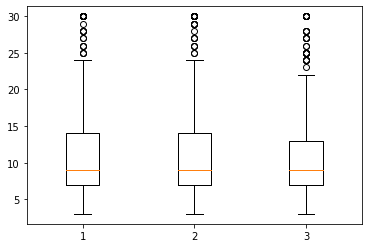

In [12]:
fig, ax = plt.subplots()
ax.boxplot(n_advs.T)
plt.show()

# Load data

In [11]:
# load data
data_natural = np.load('../data/MNIST_runs/natural_2.npy', allow_pickle=True).item()
advs = data['advs']
pert_lengths = data['pert_lengths']
classes = data['adv_class']
dirs = data['dirs']
images = data['images']
labels = data['labels']

data_madry = np.load('../data/MNIST_runs/robust_2.npy', allow_pickle=True).item()
# data = np.load('../data/CIFAR/cifarrobust.npy', allow_pickle=True).item()
# advs_madry = data['advs']
pert_lengths_madry = data_madry['pert_lengths']
# classes_madry = data['adv_class']
# dirs_madry = data['dirs']
# images_madry = data['images']
# labels_madry = data['labels']

KeyError: 'advs'

# Plot number of found dimensions

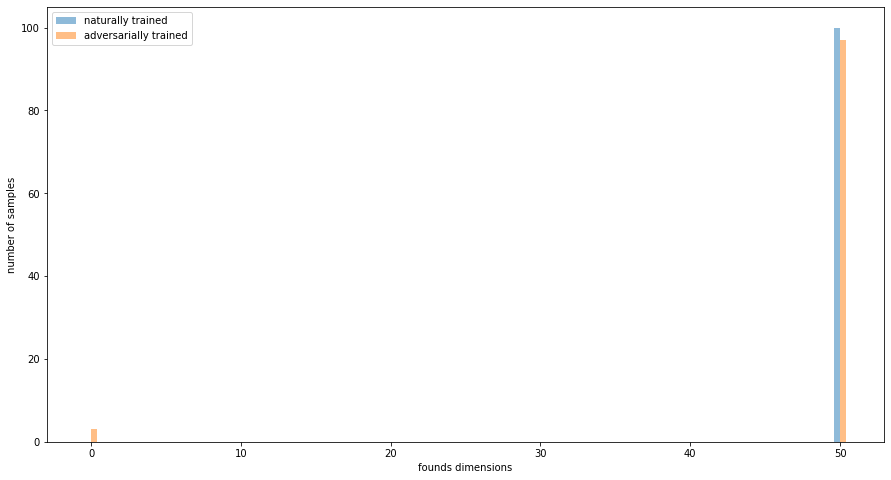

In [11]:
n_advs = np.zeros((2,len(images)))
n_advs[0,:len(classes)] = np.invert(np.isnan(pert_lengths)).sum(1)
n_advs[1] = np.invert(np.isnan(pert_lengths_madry)).sum(1)
plt.figure(figsize=(15,8))
bins = 51
plt.hist(n_advs.T, alpha=0.5, bins=bins, range=(-0.5,bins-0.5), label=['naturally trained','adversarially trained'])
plt.xlabel('founds dimensions')
plt.ylabel('number of samples')
plt.legend()

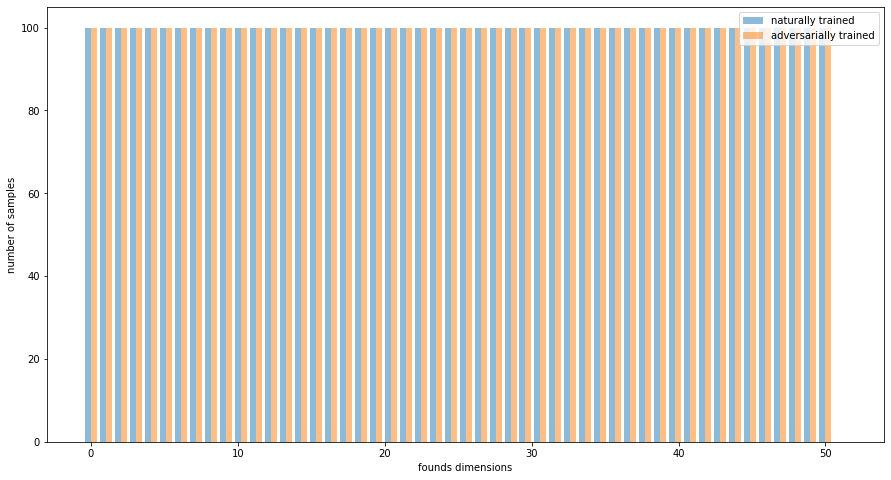

In [8]:
n_advs = np.zeros((2,len(images)))
n_advs[0] = np.invert(np.isnan(pert_lengths)).sum(1)
n_advs[1] = np.invert(np.isnan(pert_lengths_madry)).sum(1)
plt.figure(figsize=(15,8))
plt.hist(n_advs.T, alpha=0.5, bins=51, range=(-0.5,51.5), cumulative=-1, label=['naturally trained','adversarially trained'])
plt.xlabel('found dimensions')
plt.ylabel('number of samples')
plt.legend()

# Plot grid of adversarial examples

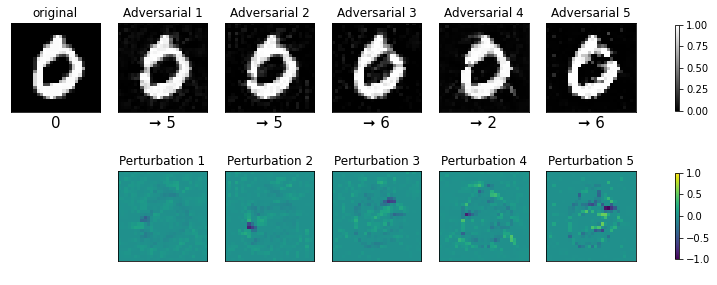

In [5]:
img_n = 0
fig , ax = pl.plot_advs(advs[img_n], orig=images[img_n], classes=classes[img_n], orig_class=labels[img_n], n=5,vmin=0,vmax=1)
fig.set_figheight(5)
fig.set_figwidth(14)


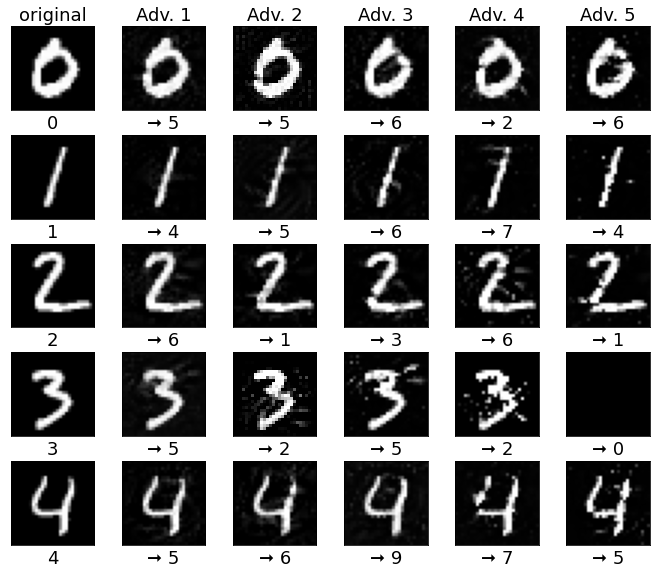

In [6]:
fig, ax = plt.subplots(5, 6, squeeze=False, figsize=(9,8))
for j in range(5):
    orig = np.reshape(images[j*50], [28, 28])
    if j == 0:
        ax[j, 0].set_title('original', fontsize=18)
    ax[j, 0].imshow(orig, cmap='gray', vmin=0, vmax=1)
    ax[j, 0].set_xticks([])
    ax[j, 0].set_yticks([])
    ax[j, 0].set_xlabel(str(labels[j*50]), fontdict={'fontsize': 18})

    for i, a in enumerate(advs[j*50,:5]):
        if j==0:
            ax[j, i+1].set_title('Adv. ' + str(i + 1), fontsize=18)
        ax[j, i+1].set_xlabel('\u279E ' + str(int(classes[j*50,i])), fontdict={'fontsize': 18})
        ax[j, i+1].imshow(a.reshape([28, 28]), cmap='gray', vmin=0, vmax=1)
        ax[j, i+1].set_xticks([])
        ax[j, i+1].set_yticks([])
plt.subplots_adjust(hspace=0.3, left=0, right=1, bottom=0.05, top=0.95)
plt.show()

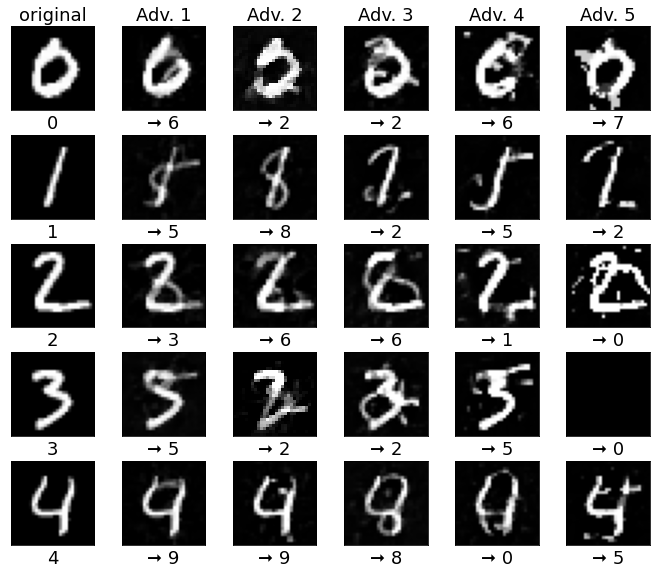

In [51]:
fig, ax = plt.subplots(5, 6, squeeze=False, figsize=(9,8))
for j in range(5):
    orig = np.reshape(images[j*50], [28, 28])
    if j == 0:
        ax[j, 0].set_title('original', fontsize=18)
    ax[j, 0].imshow(orig, cmap='gray', vmin=0, vmax=1)
    ax[j, 0].set_xticks([])
    ax[j, 0].set_yticks([])
    ax[j, 0].set_xlabel(str(labels[j*50]), fontdict={'fontsize': 18})

    for i, a in enumerate(advs_madry[j*50,:5]):
        if j==0:
            ax[j, i+1].set_title('Adv. ' + str(i + 1), fontsize=18)
        ax[j, i+1].set_xlabel('\u279E ' + str(int(classes_madry[j*50,i])), fontdict={'fontsize': 18})
        ax[j, i+1].imshow(a.reshape([28, 28]), cmap='gray', vmin=0, vmax=1)
        ax[j, i+1].set_xticks([])
        ax[j, i+1].set_yticks([])
plt.subplots_adjust(hspace=0.3, left=0, right=1, bottom=0.05, top=0.95)
plt.show()

# Plot madry and natural adversarial examples in one figure

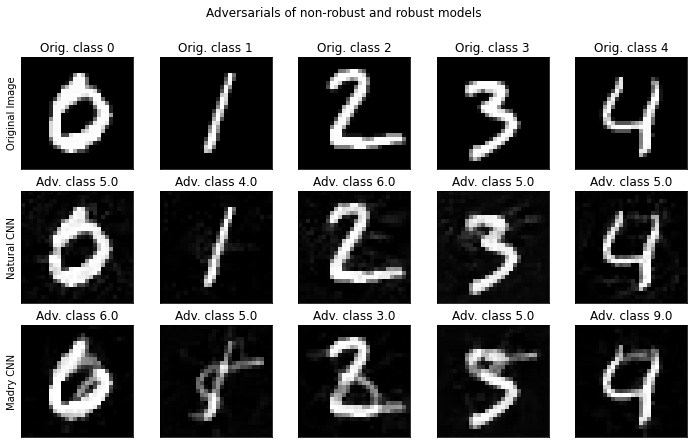

In [8]:
plt.figure(figsize=(12,7))
for i in range(5):
    plt.subplot(3,5,1+i)
    plt.title('Orig. class ' + str(labels[i*50]))
    plt.imshow(np.reshape(images[i*50], [28,28]), cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel("Original Image")
    
    plt.subplot(3,5,6+i)
    plt.title('Adv. class ' + str(classes[i*50,0]))
    plt.imshow(np.reshape(advs[i*50,0], [28,28]), cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel("Natural CNN")

    plt.subplot(3,5,11+i)
    plt.title('Adv. class ' + str(classes_madry[i*50,0]))
    plt.imshow(np.reshape(advs_madry[i*50,0], [28,28]), cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel("Madry CNN")
plt.suptitle('Adversarials of non-robust and robust models')
plt.show()

# Perturbation Length comparison

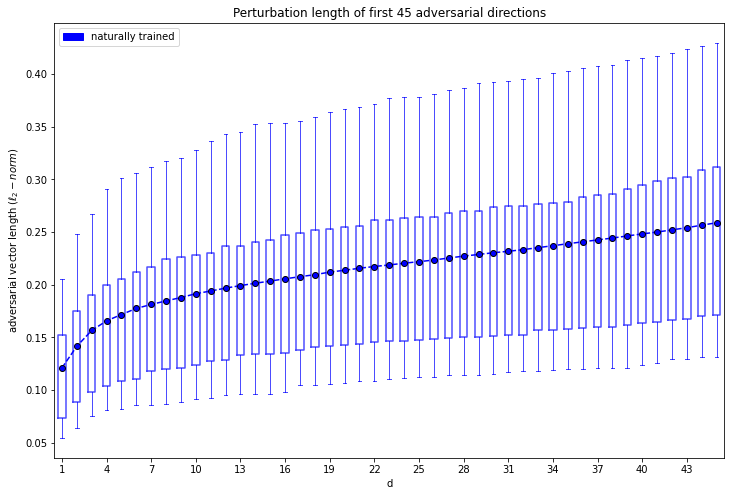

In [12]:
# plot with all adversarials included
fig , ax = pl.plot_pert_lengths([pert_lengths,pert_lengths_madry],  n=45, labels=['naturally trained','adversarially trained'], ord=2)
fig.set_figheight(8)
fig.set_figwidth(12)
ax.set_xticks(np.arange(1,45,3))
ax.set_xticklabels(np.arange(1,45,3))
plt.show()


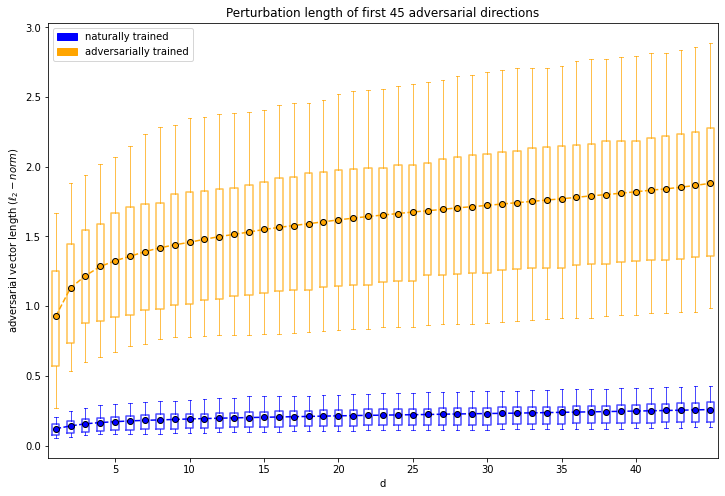

In [23]:
### only samples with at least n adversarials included
n=45

p_robust = pert_lengths_madry[np.invert(np.isnan(pert_lengths_madry)).sum(-1)>=n]
p_natural = pert_lengths[np.invert(np.isnan(pert_lengths)).sum(-1)>=n]

        
fig , ax = pl.plot_pert_lengths([p_natural,p_robust],  n=n, labels=['naturally trained','adversarially trained'], ord=2)
fig.set_figheight(8)
fig.set_figwidth(12)
ax.set_xticks(np.arange(5,n,5))
ax.set_xticklabels(np.arange(5,n,5))
plt.show()

Text(0, 0.5, 'number of shifts')

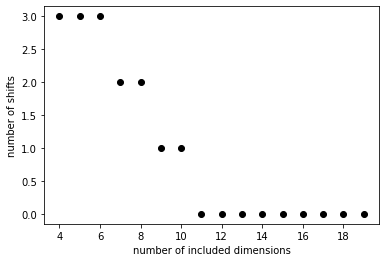

In [53]:
for n in np.arange(4,20):
    tests = np.zeros(n)
    p_robust = pert_lengths_madry[np.invert(np.isnan(pert_lengths_madry)).sum(-1)>=n]
    p_natural = pert_lengths[np.invert(np.isnan(pert_lengths)).sum(-1)>=n]
    for i in range(n):
        tests[i]=kstest(p_natural[:,i], p_robust[:,0]).statistic
    plt.scatter(n,np.argmin(tests),c='k')
plt.xlabel('number of included dimensions')
plt.ylabel('number of shifts')
    


# Epsilon vs dimnesionality

In [13]:
epsilons = np.arange(0,4,.001)
n_dims_natural = np.zeros((len(epsilons),len(images)))
n_dims_robust = np.zeros((len(epsilons),len(pert_lengths_madry[pert_lengths_madry[:,0]>0])))
for i, e in enumerate(epsilons):
    n_dims_natural[i,:len(classes)] = (pert_lengths < e).sum(-1)
    n_dims_robust[i] = (pert_lengths_madry[pert_lengths_madry[:,0]>0] < e).sum(-1)

NameError: name 'bars' is not defined

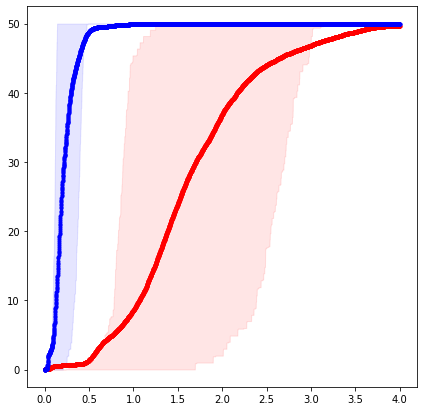

In [14]:
percentiles_natural = np.percentile(n_dims_natural, [10,90], axis=-1)
means_natural = np.mean(n_dims_natural,axis=-1)
errors_natural = percentiles_natural.copy()
errors_natural[0] = means_natural-percentiles_natural[0]
errors_natural[1] = percentiles_natural[1] - means_natural

percentiles_robust = np.percentile(n_dims_robust, [10,90], axis=-1)
means_robust = np.mean(n_dims_robust,axis=-1)
errors_robust = percentiles_robust.copy()
errors_robust[0] = means_robust-percentiles_robust[0]
errors_robust[1] = percentiles_robust[1] - means_robust

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(epsilons, means_robust,'.r',  label='robust')
ax.fill_between(epsilons, (means_robust-errors_robust[0]), (means_robust+errors_robust[1]), color='r', alpha=.1)
ax.plot(epsilons, means_natural,'.b',  label='natural')
ax.fill_between(epsilons, (means_natural-errors_natural[0]), (means_natural+errors_natural[1]), color='b', alpha=.1)
# ax.plot(np.arange(1,9),np.nanmean(pert_lengths[np.invert(np.isnan(pert_lengths)).sum(-1)>8,:8], axis=0),'b.')
[bar.set_alpha(0.2) for bar in bars]
plt.ylabel('dimension of adversarial space')
plt.xlabel('distance to decision boundary')
# plt.xticks(epsilons[0:.1:])
plt.legend()
plt.show()
# dists


# Plot variation of target classes

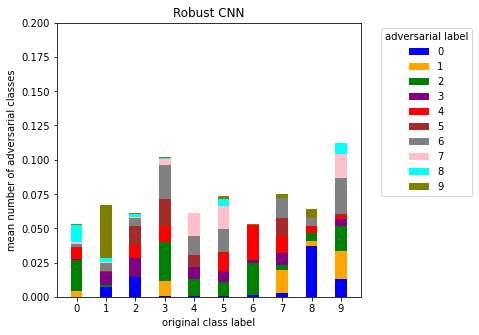

In [56]:
classes_ = classes_madry.copy()
pert_lengths_ = pert_lengths_madry.copy()

mask_idx = np.invert(np.isnan(pert_lengths_)).sum(1)>2
classes_[np.isnan(pert_lengths_)]=np.nan
classes_ = classes_[mask_idx]
labels_ = labels[mask_idx]
fig, ax = pl.plot_var_hist(classes_, labels_, title='Robust CNN', with_colors = True)
fig.set_figheight(5)
fig.set_figwidth(7)
plt.ylim(0,.2)
plt.show()

In [53]:
advs_per_class = np.zeros(10)
for l in range(10):
    p = pert_lengths[labels==l]
    advs_per_class[l] = np.mean(np.invert(np.isnan(p)).sum(1))
plt.figure(figsize=(7,5))
plt.bar(range(10),advs_per_class)
plt.xticks(np.arange(0,10))
plt.xlabel('original class label')
plt.ylabel('mean number of dirs found')
plt.title('Natural Model')
plt.ylim(0,25)
plt.show()
# print(np.mean(advs_per_class),np.mean(np.invert(np.isnan(pert_lengths)).sum(1)))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 20 but corresponding boolean dimension is 100

# Distance to decision boundary

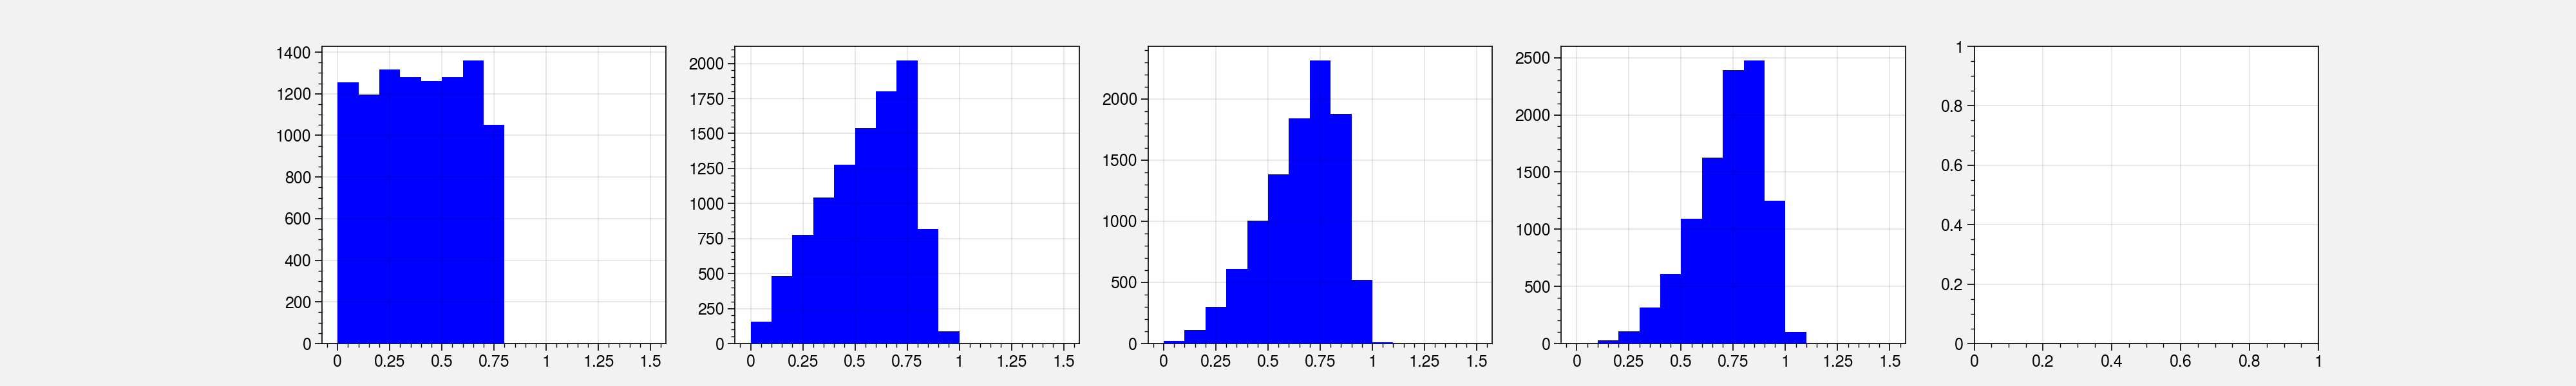

In [8]:
fig, axs = plt.subplots(1,5, figsize=(20,3))
for n_dirs in range(2,6):
    n_samples=10000
    dirs_ = dirs[0, :n_dirs]
    n_dirs = len(dirs_)
    dirs_ = dirs_.reshape((n_dirs, -1))

    coeffs = abs(np.random.normal(0,1,size=[n_samples, n_dirs]))
    norms = np.linalg.norm(coeffs, axis=0, keepdims=True)
    coeffs=coeffs/norms
    sample_dirs = (coeffs @ dirs_)
    sample_dirs = sample_dirs / np.linalg.norm(sample_dirs, axis=-1, keepdims=True)

    angles = np.arccos((sample_dirs@dirs_.T).clip(-1,1)).min(-1)
    axs[n_dirs-2].hist(angles.flatten(), bins=np.arange(0,1.6,.1), color='blue')
plt.show()

In [19]:
def get_dist_dec(orig, label, dirs, model, max_dist=10, n_samples=1000, return_angles=False):
    shape = orig.shape
    n_steps = 20
    n_dirs = len(dirs)
    dirs = dirs.reshape((n_dirs, -1))

    upper = np.ones((n_samples, 1)) * max_dist
    lower = np.zeros((n_samples, 1))

    scales = np.ones((n_samples, 1)) * max_dist

    coeffs = abs(np.random.normal(size=[n_samples, n_dirs]))
    sample_dirs = (coeffs @ dirs)
    sample_dirs = sample_dirs / np.linalg.norm(sample_dirs, axis=-1, keepdims=True)

    dists = np.full(n_samples, np.nan)

    for i in range(n_steps):
        input_dirs = scales * sample_dirs
        input_ = (input_dirs + orig.flatten()[None])
        input = torch.split(torch.tensor(input_.reshape((-1,) + shape), device=dev()), 100)

        preds = np.empty((0, 10))
        for batch in input:
            preds = np.concatenate((preds, model(batch).detach().cpu().numpy()), axis=0)
        pred_classes = np.argmax(preds, axis=-1)

        is_adv = np.invert(pred_classes == label)
        dists[is_adv] = scales[is_adv, 0]

        upper[is_adv] = scales[is_adv]
        lower[~is_adv] = scales[~is_adv]
        scales[is_adv] = upper[is_adv] / 2
        scales[~is_adv] = (upper[~is_adv] + lower[~is_adv]) / 2

    in_bounds = np.logical_or(input_.max(-1) <= 1, input_.min(-1) >= 0)
    dists[~in_bounds] = np.nan

    if return_angles:
        angles = np.arccos((sample_dirs@dirs.T).clip(-1,1))
        angles[np.isnan(dists)] = np.nan
        return dists, angles
    return dists


In [20]:
n_samples = 5
n_dims = 2
n_images = 1

img_indices = np.random.choice(np.arange(100), size=n_images,replace=False)

#natural
images_ = images[img_indices]
labels_ = labels[img_indices]
dirs_ = dirs[img_indices]
dists_natural = np.zeros((len(images_),n_dims,n_samples))
angles_natural = np.zeros((len(images_), n_dims, n_samples))

for i, img in enumerate(tqdm.tqdm(images_)):
    for n in np.arange(1,n_dims+1):
        dists_natural[i, n-1], angles_natural[i, n-1] = get_dist_dec(img, labels_[i], dirs_[i, :n], model_natural,
                                             n_samples=n_samples, max_dist=5, return_angles=True)

#robust
# dirs_ = dirs_madry[img_indices]
# dists_robust = np.zeros((len(images_), n_dims, n_samples))

# for i, img in enumerate(tqdm.tqdm(images_)):
#     for n in np.arange(1, n_dims + 1):
#         dists_robust[i, n - 1] = get_dist_dec(img, labels_[i], dirs_[i, :n], model_robust, n_samples=n_samples)
    

100%|██████████| 1/1 [00:08<00:00,  8.76s/it]


In [14]:
data= np.load('../data/dists_to_bnd2.npy', allow_pickle=True).item()
dists_natural = data['dists_natural']
dists_robust = data['dists_robust']
dists_natural[dists_natural==0]=np.nan
dists_robust[dists_robust==0]=np.nan

angles_natural = data['angles_natural']
angles_robust = data['angles_robust']
angles_natural[np.isnan(dists_natural)]=np.nan
angles_robust[np.isnan(dists_robust)]=np.nan

In [16]:
np.isnan(dists_natural[:,0,0]).sum()

94

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

Mean of empty slice



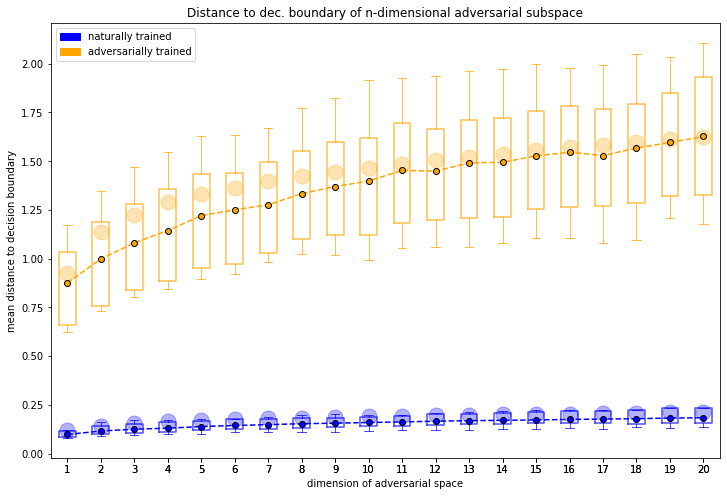

NameError: name 'dists' is not defined

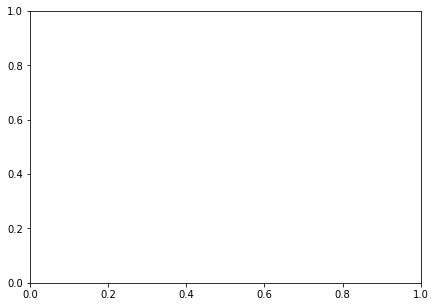

In [26]:
n_dims = 20
mean_dists_natural = np.nanmean(dists_natural,axis=-1)
mean_dists_robust = np.nanmean(dists_robust,axis=-1)

# plot with all adversarials included
fig , ax = pl.plot_pert_lengths([mean_dists_natural,mean_dists_robust],  n=n_dims, labels=['naturally trained','adversarially trained'], ord=2)
fig.set_figheight(8)
fig.set_figwidth(12)
ax.plot(np.arange(1,n_dims+1),np.nanmean(pert_lengths_madry[:,:n_dims], axis=0),'o', color='orange', ms=15, alpha = .3)
ax.plot(np.arange(1,n_dims+1),np.nanmean(pert_lengths[:,:n_dims], axis=0),'o', color='blue', ms=15, alpha=.3)
plt.xlabel('dimension of adversarial space')
plt.ylabel('mean distance to decision boundary')
plt.title('Distance to dec. boundary of n-dimensional adversarial subspace')
plt.show()



### MNIST
# fig, ax = plt.subplots(figsize=(7,5))
# mean_dists = np.nanmean(dists,axis=-1)
# mask = ~np.isnan(mean_dists)
# filtered_data = [d[m] for d, m in zip(mean_dists.T, mask.T)]
# ax.boxplot(filtered_data)
# ax.plot(np.arange(1,n_dims+1),np.nanmean(pert_lengths_madry[np.invert(np.isnan(pert_lengths_madry)).sum(-1)>n_dims,:n_dims], axis=0),'b.')

# plt.ylim(0,3)
# plt.show()


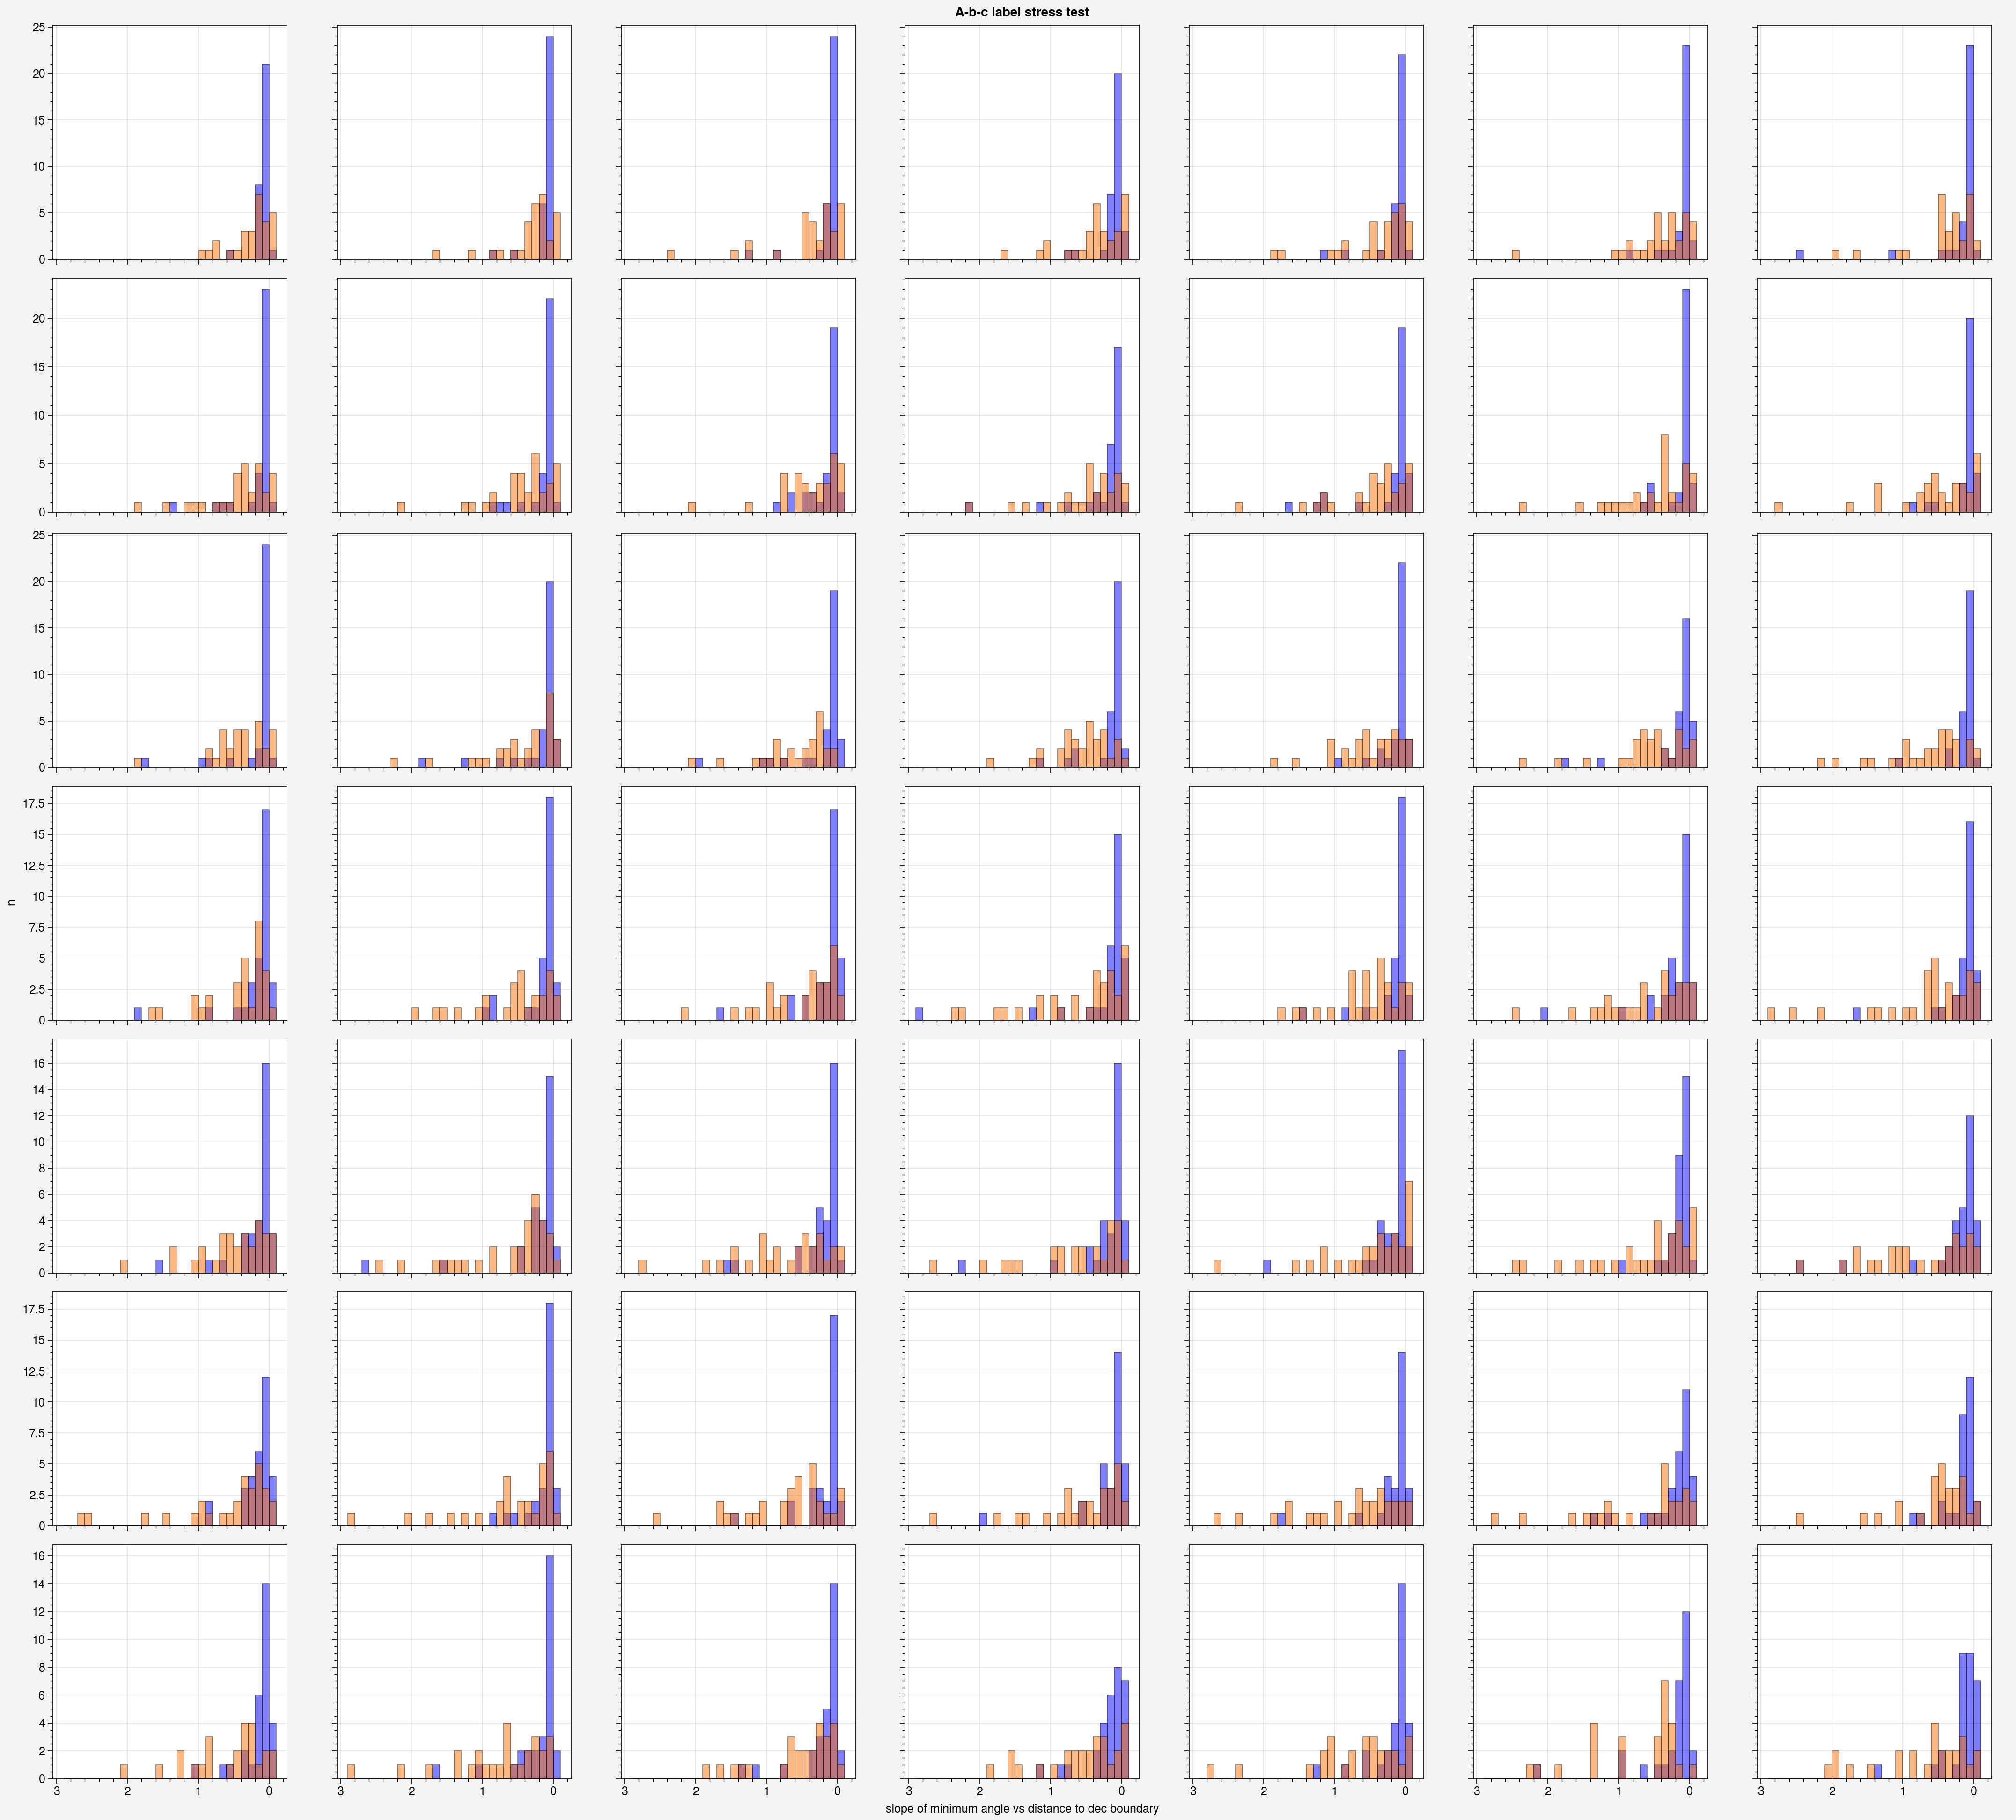

In [13]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)
n_cols = 7
n_rows = 7


# slopes_natural = np.zeros(dists_natural.shape[:-1])
# slopes_robust = np.zeros(dists_natural.shape[:-1])

# for img_n in range(len(dists_natural)):
#     for dim in range(1,dists_natural.shape[1]):
#         if np.all(np.isnan(dists_natural[img_n,dim])):
#             slopes_natural[img_n, dim] = np.nan
#         else:
#             angles_ = angles_natural[img_n,dim][np.isfinite(dists_natural[img_n,dim])]
#             dists_ = dists_natural[img_n,dim][np.isfinite(dists_natural[img_n,dim])]
#             slopes_natural[img_n, dim] = np.polyfit(angles_, dists_, deg=1)[0]
#         if np.all(np.isnan(dists_robust[img_n,dim])):
#             slopes_robust[img_n, dim] = np.nan
#         else:
#             angles_ = angles_robust[img_n,dim][np.isfinite(dists_robust[img_n,dim])]
#             dists_ = dists_robust[img_n,dim][np.isfinite(dists_robust[img_n,dim])]
#             slopes_robust[img_n, dim] = np.polyfit(angles_, dists_, deg=1)[0]


fig, axs = pplt.subplots(nrows=n_rows, ncols=n_cols)
axs.format(
    xlabel='slope of minimum angle vs distance to dec boundary', ylabel='n',
    suptitle='A-b-c label stress test'
)    
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)            
for i in range(n_rows*n_cols):
    axs[int(i/n_cols),(i%n_cols)].hist(slopes_natural[:,i+1].flatten(), bins=np.arange(-0.1,3,.1), color='blue', alpha=.5)
    axs[int(i/n_cols),(i%n_cols)].hist(slopes_robust[:,i+1].flatten(), bins=np.arange(-0.1,3,.1), color='orange', alpha=.5)
plt.show()

# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3,n_rows*3,), sharex=True, sharey=True)

# for i in range(n_rows*n_cols):
#     axs[int(i/n_cols),(i%n_cols)].hist(slopes_natural[:,i+1].flatten(), bins=np.arange(-0.1,2,.1), color='orange')
# fig.text(0.5, 0.07, 'slope of minimum angle vs distance to dec boundary', ha='center')
# fig.text(0.1, 0.5, 'n', va='center', rotation='vertical', fontsize=16)
# plt.show()

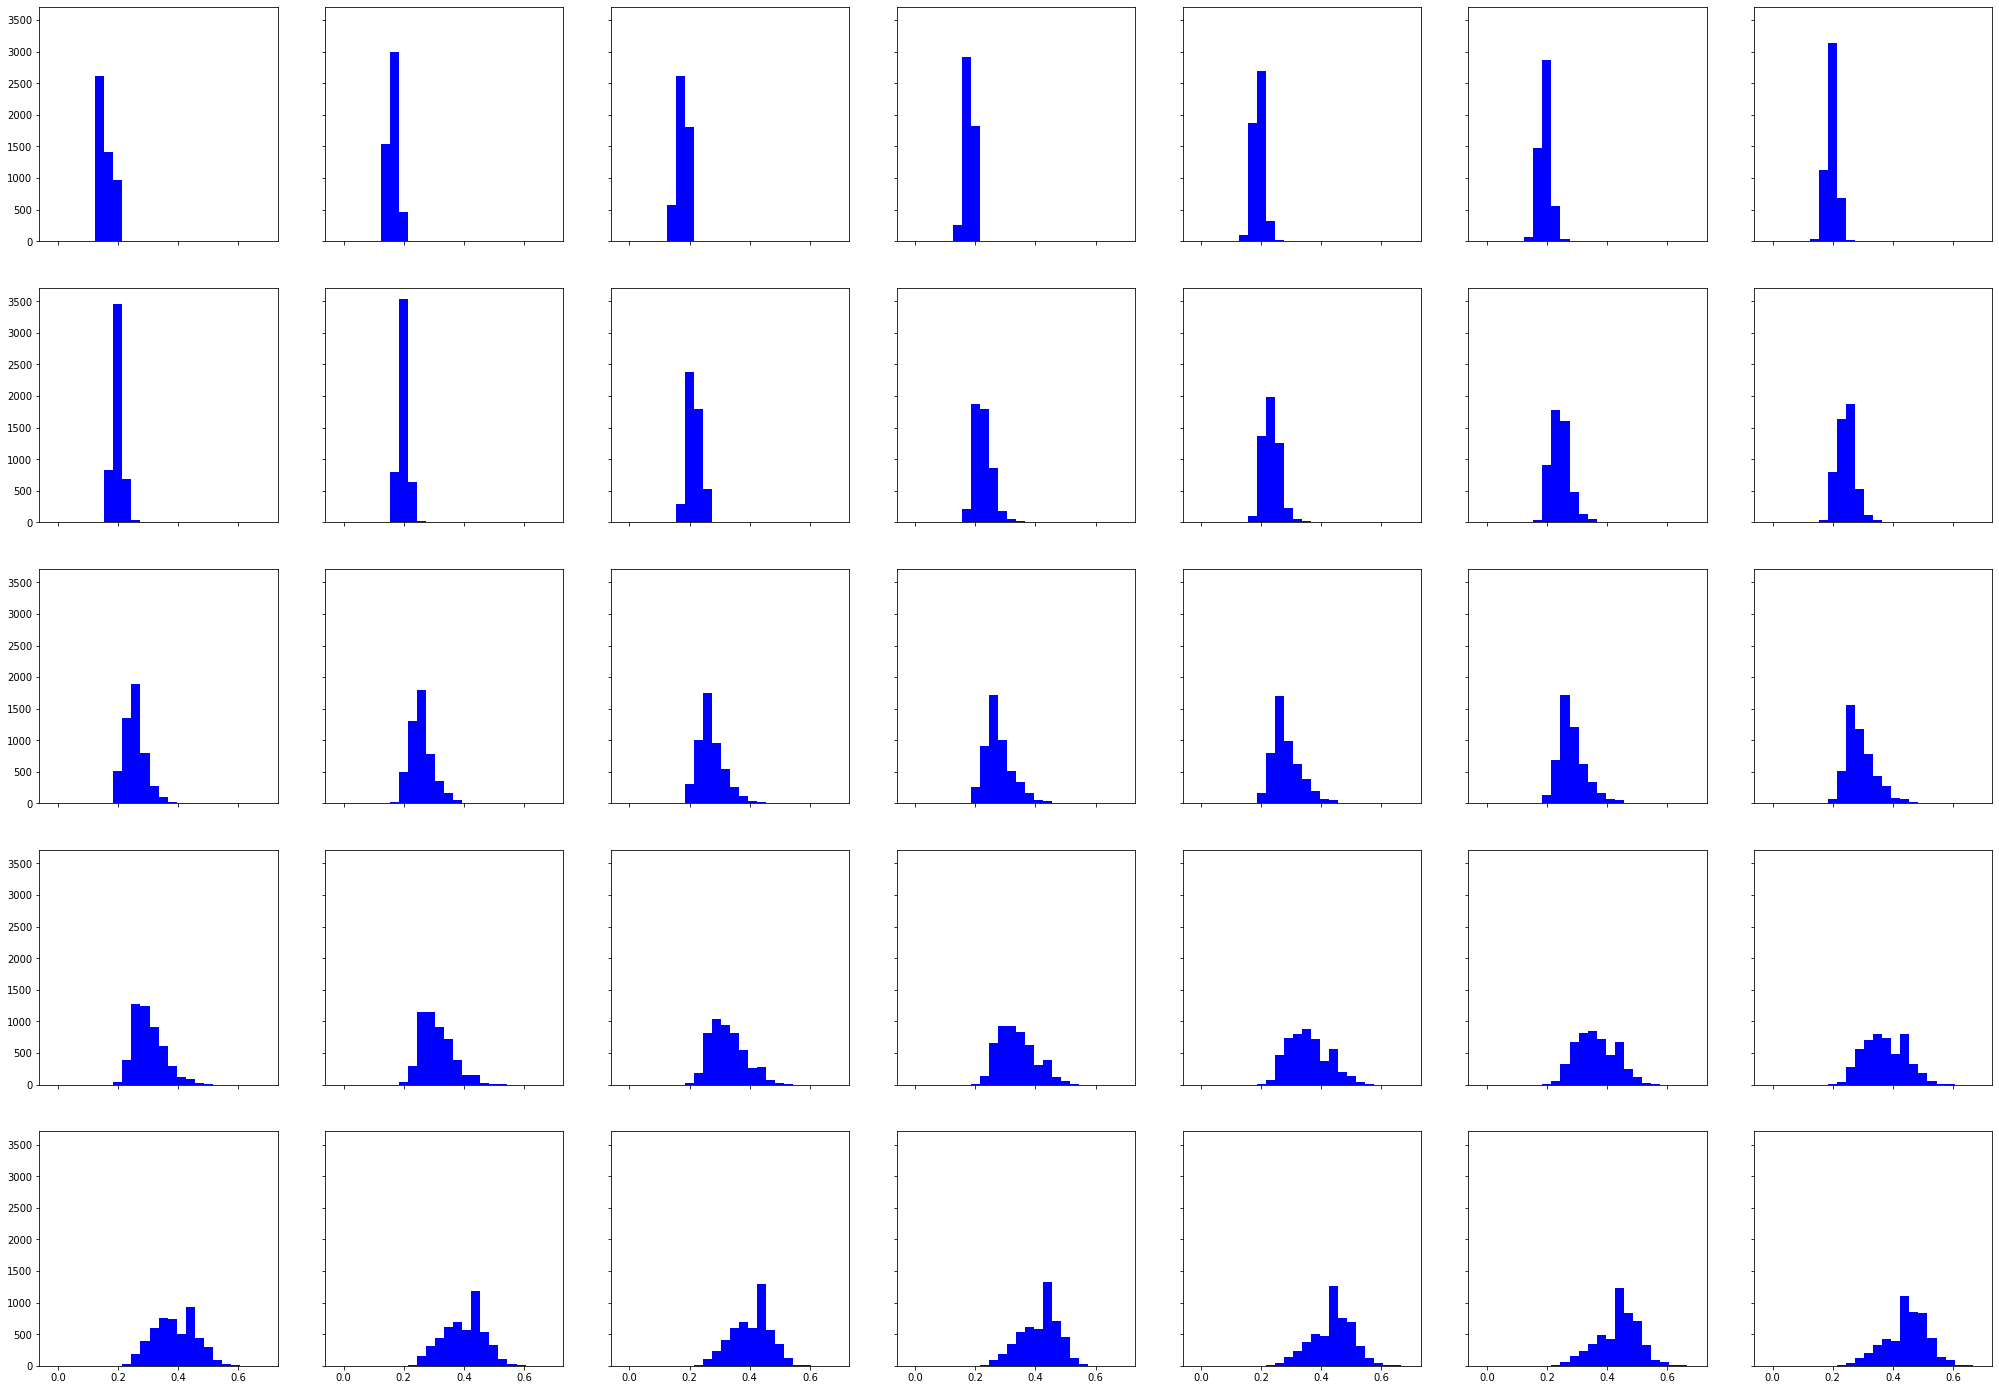

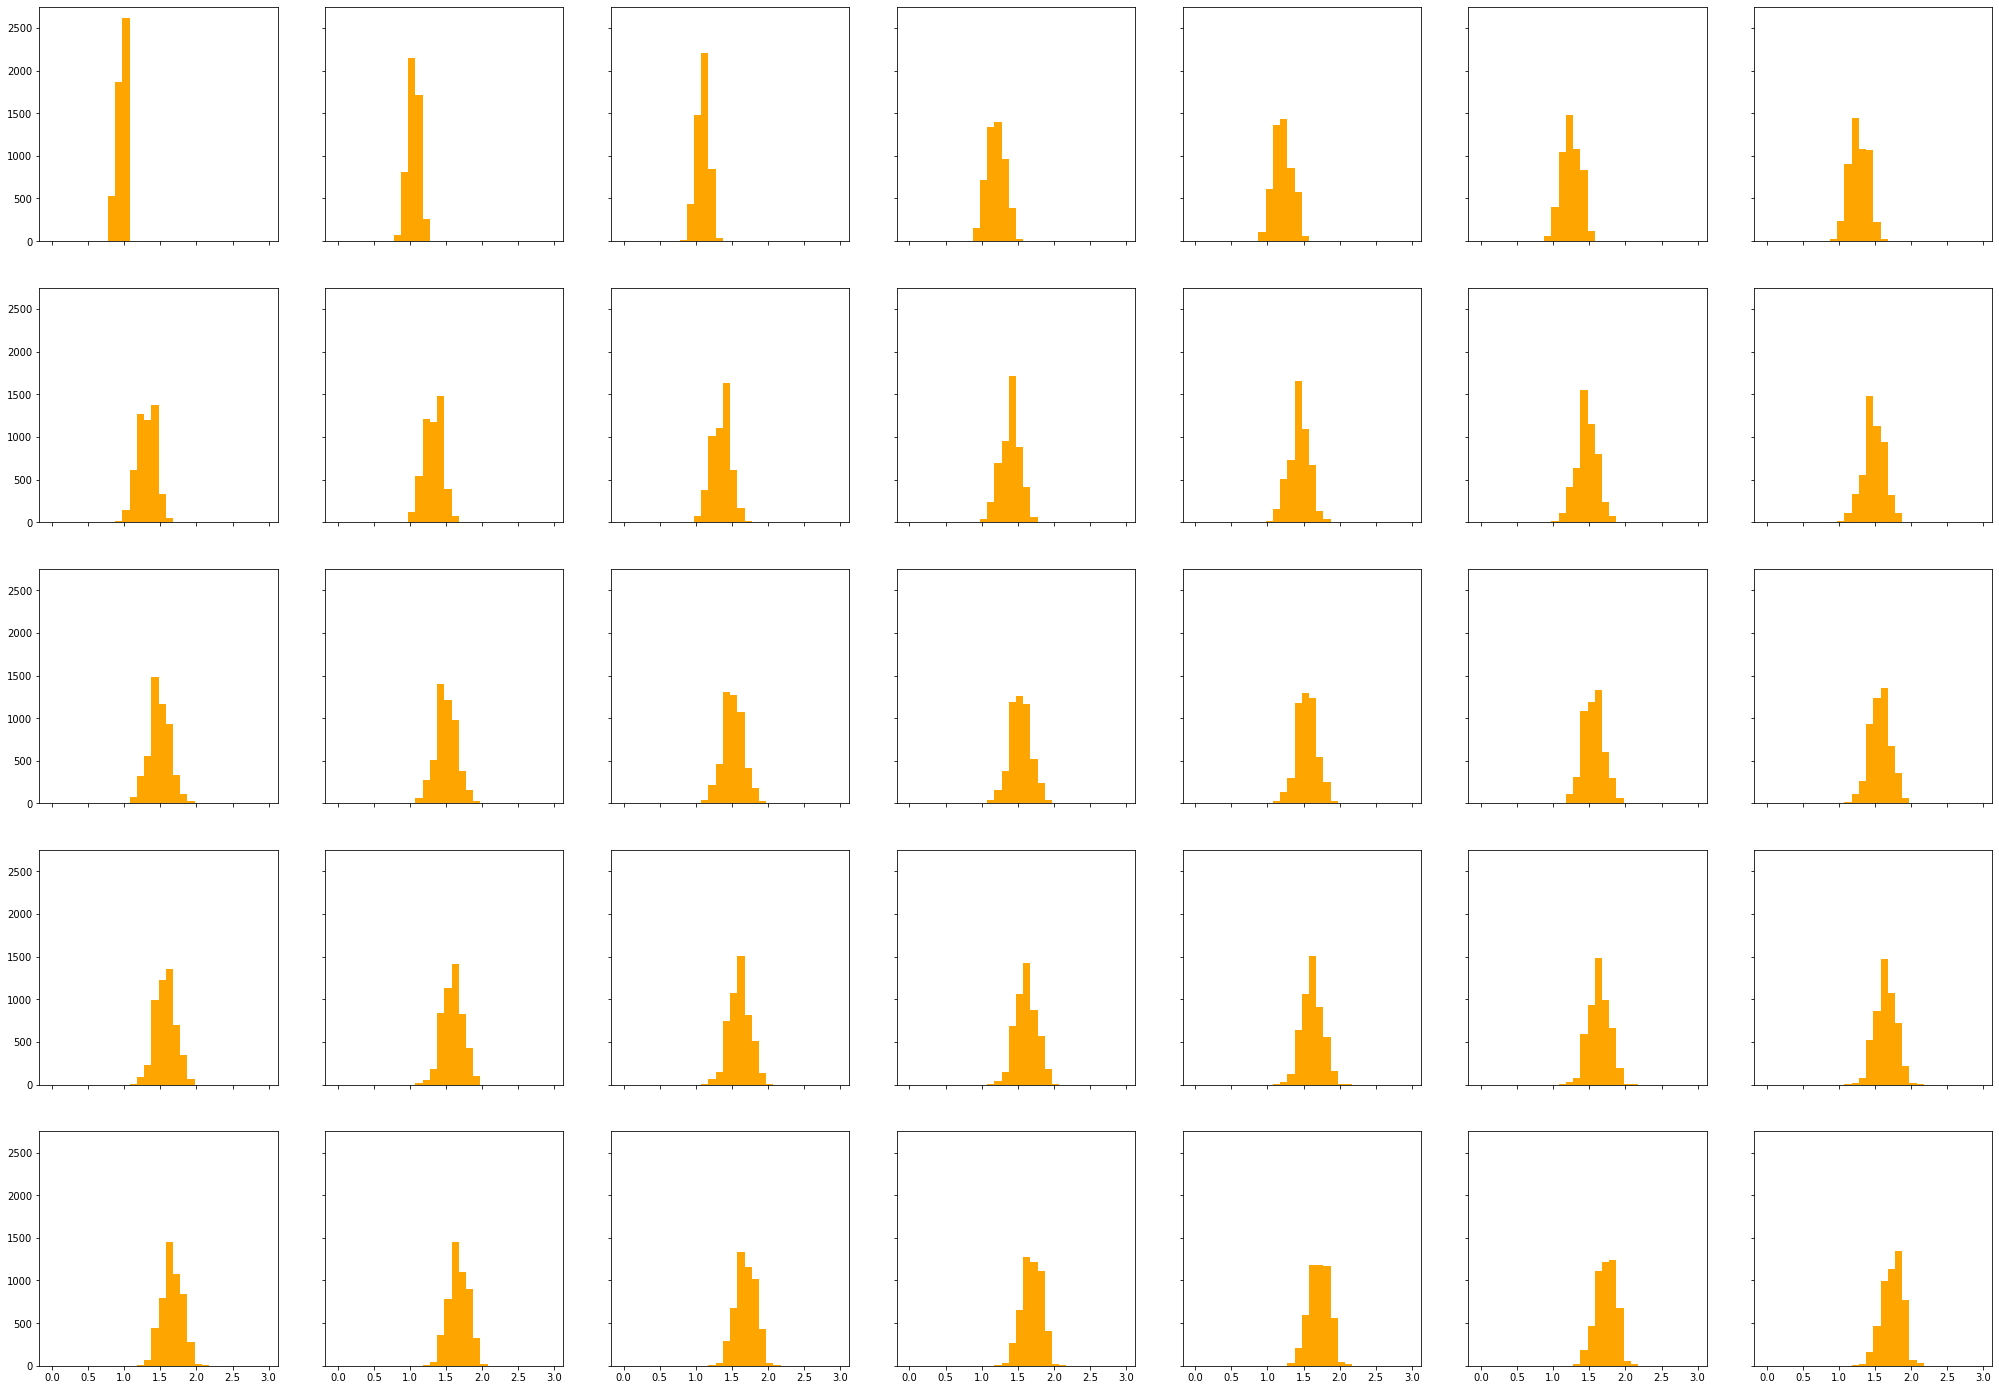

In [30]:
n_cols = 7
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5,n_rows*5,), sharex=True, sharey=True)

for i in range(n_rows*n_cols):
    axs[int(i/n_cols),(i%n_cols)].hist(dists_natural[:,i+1].flatten(), bins=np.arange(-0.025,.7,.03), color='blue')
    

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5,n_rows*5,), sharex=True, sharey=True)

for i in range(n_rows*n_cols):
    axs[int(i/n_cols),(i%n_cols)].hist(dists_robust[:,i+1].flatten(), bins=np.arange(-0.025,3,.1), color='orange')

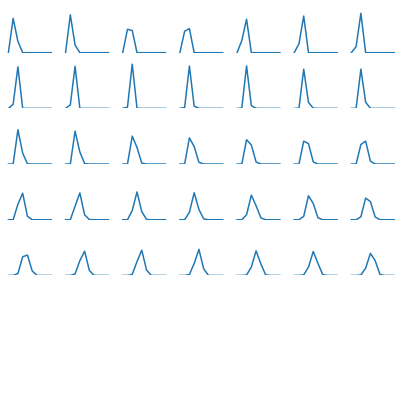

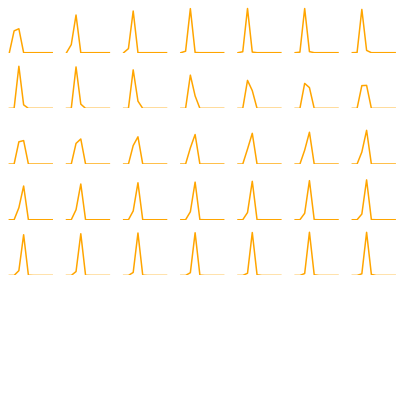

In [26]:
n_cols = 7
n_rows = 7

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)
bins = np.arange(-0.025,1,.1)
for i in range(n_rows*n_cols):
#     sns.kdeplot(x=dists_natural[:,i+1].flatten(), bw_method='scott', ax = axs[int(i/n_cols),(i%n_cols)])
    sns.histplot(x=dists_natural[:,i+1].flatten(), bins=bins, stat='density', ax = axs[int(i/n_cols),(i%n_cols)], element='poly', fill=False)
plt.xlim(0,1)
[axi.set_axis_off() for axi in axs.ravel()]
plt.show()

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)
bins = np.arange(-0.025,5,.5)
for i in range(n_rows*n_cols):
#     sns.kdeplot(x=dists_robust[:,i+1].flatten(), bw_method='scott', ax = axs[int(i/n_cols),(i%n_cols)], color='orange')
    sns.histplot(x=dists_robust[:,i+1].flatten(), bins=bins, stat='density', ax = axs[int(i/n_cols),(i%n_cols)], element='poly', fill=False, color='orange')
plt.xlim(0,5)
[axi.set_axis_off() for axi in axs.ravel()]
plt.show()

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

Mean of empty slice



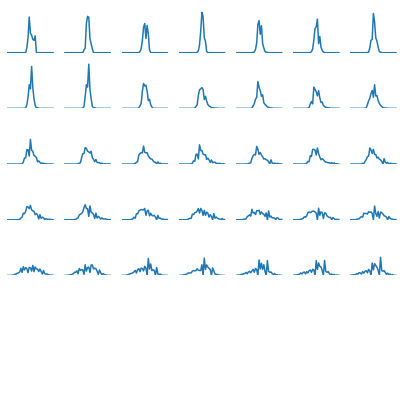

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

Mean of empty slice



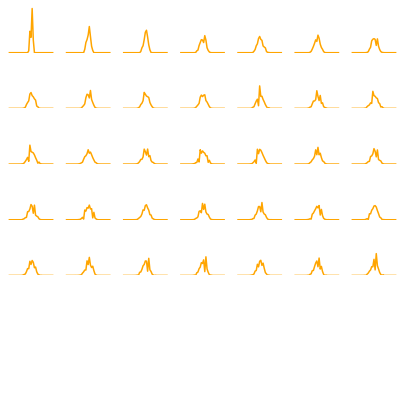

In [31]:
n_cols = 7
n_rows = 7
n_dims=50
bins = np.arange(-0.2,0.2,0.01)
hist_data = dists_natural-np.nanmean(dists_natural,axis=-1,keepdims=True)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)
for i in range(n_rows*n_cols):
#     hist = np.histogram(hist_data[:,i+1].flatten(), bins=bins)[0]
#     axs[int(i/n_cols),(i%n_cols)].hist(hist_data[:,i+1].flatten(), bins=bins)
    sns.histplot(x=hist_data[:,i+1].flatten(), bins=bins, stat='density', ax = axs[int(i/n_cols),(i%n_cols)], element='poly', fill=False)
plt.xlim(-.2,.2)
[axi.set_axis_off() for axi in axs.ravel()]
plt.show()

bins = np.arange(-1,1,0.05)
hist_data = dists_robust-np.nanmean(dists_robust,axis=-1,keepdims=True)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)
for i in range(n_rows*n_cols):
    sns.histplot(x=hist_data[:,i+1].flatten(), bins=bins, stat='density', ax = axs[int(i/n_cols),(i%n_cols)], element='poly', fill=False, color='orange')
[axi.set_axis_off() for axi in axs.ravel()]
plt.show()

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning:

Degrees of freedom <= 0 for slice.



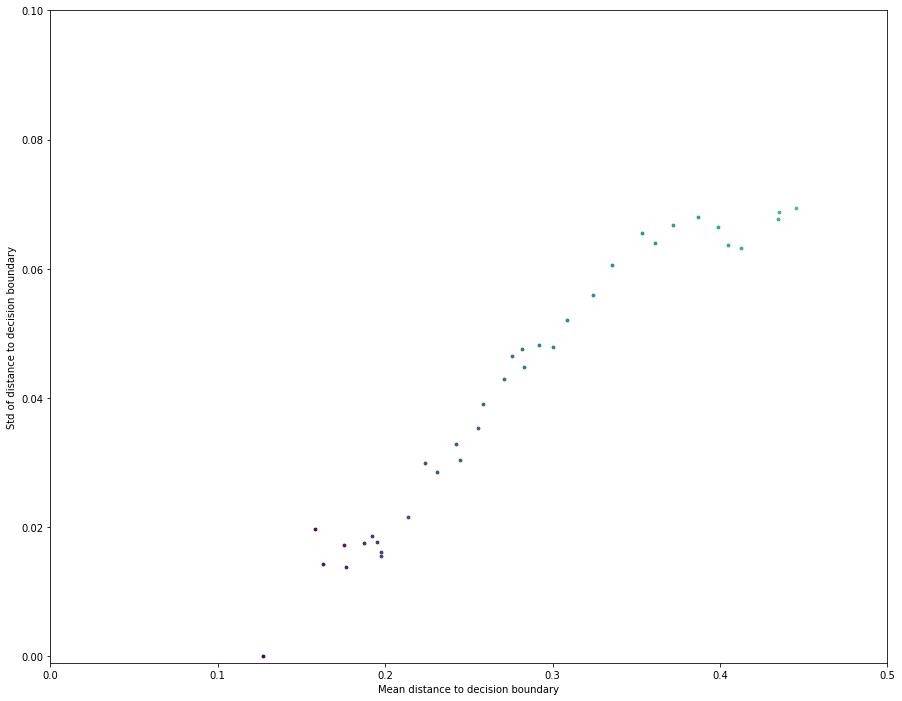

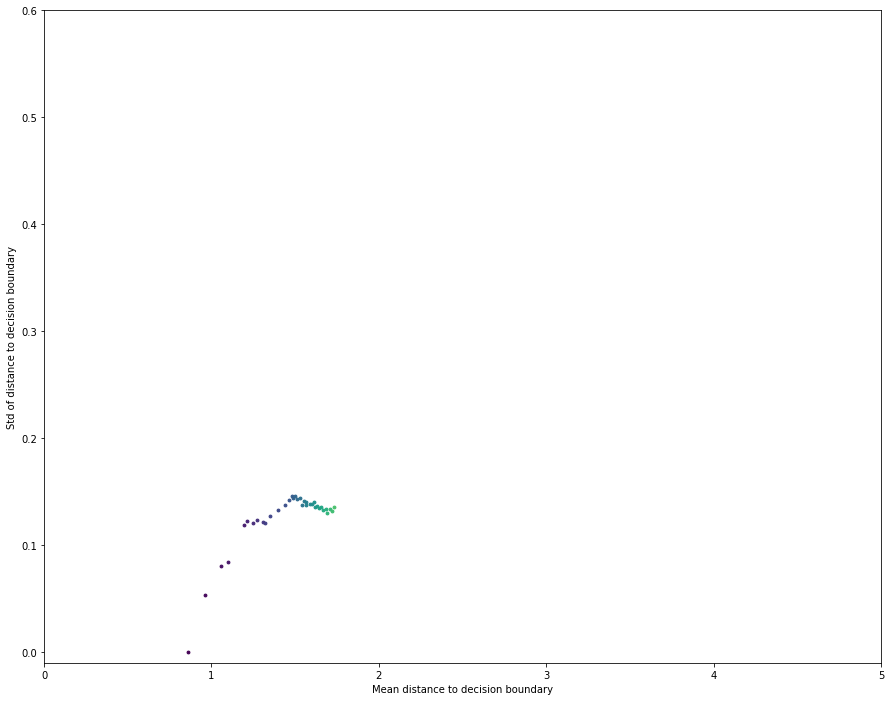

In [32]:
mean_natural = np.nanmean(dists_natural,axis=-1)
mean_robust = np.nanmean(dists_robust,axis=-1)

std_natural = np.nanstd(dists_natural, axis=-1)
std_robust = np.nanstd(dists_robust, axis=-1)

n_dims = 50
col_range = np.linspace(0,1,n_dims, endpoint=True)
cmap=plt.get_cmap('viridis')
colors = [cmap(x) for x in col_range]

plt.figure(figsize=(15,12))
for dim in range(n_dims):
    plt.scatter(mean_natural[:,dim], std_natural[:,dim], s=8, color=colors[dim])
plt.xlabel('Mean distance to decision boundary')
plt.ylabel('Std of distance to decision boundary')
plt.ylim(-.001,.1)
plt.xlim(0,.5)
plt.show()

plt.figure(figsize=(15,12))
for dim in range(n_dims):
    plt.scatter(mean_robust[:,dim], std_robust[:,dim], s=8, color=colors[dim])
plt.xlabel('Mean distance to decision boundary')
plt.ylabel('Std of distance to decision boundary')
plt.ylim(-.01,.6)
plt.xlim(0,5)
plt.show()

Text(0, 0.5, 'rate of out of bounds samples')

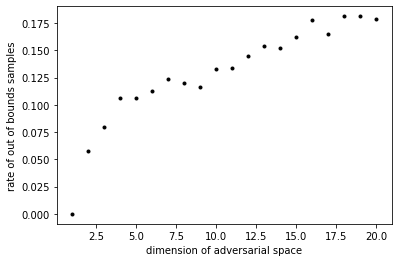

In [50]:
plt.plot(np.arange(1,n_dims+1),np.mean(np.isnan(dists_robust[:8,:n_dims]).sum(-1),axis=0)/dists_robust.shape[-1],'k.')
plt.xlabel('dimension of adversarial space')
plt.ylabel('rate of out of bounds samples')

# Decision Space Visualization

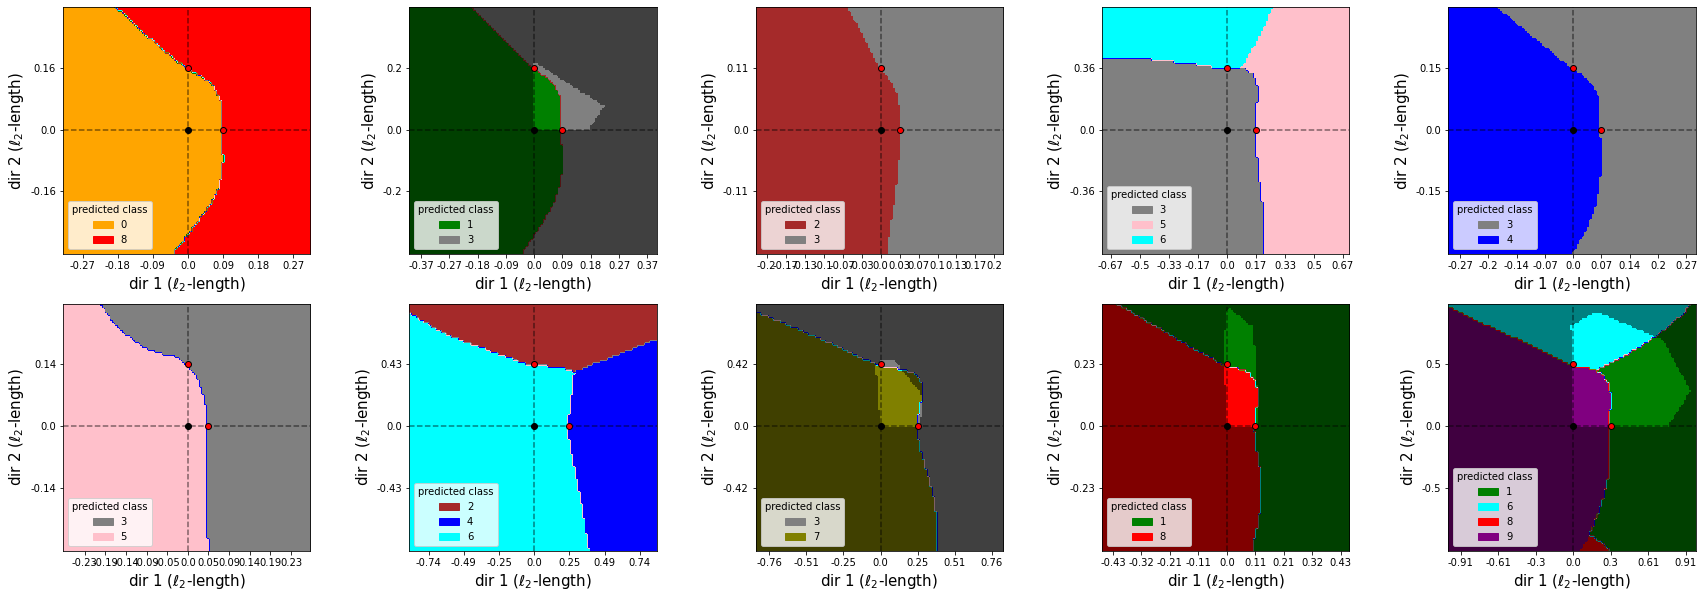

In [6]:
n_rows = 2
n_cols = 5
fig, axs = plt.subplots(2,5)
# fig2 = plt.figure()
# fig2.axes.append(ax)
for i, img_n in enumerate([0,10,20,30,40,50,60,70,80,90]):
    orig = images[img_n]
    adv1 = advs[img_n,0]
    adv2 = advs[img_n,40]
    model_ = model_natural
    pl.plot_dec_space(orig, adv1, adv2, model_,n_grid=100, origin_centered=True, show_legend=True, show_advs=True, overlay_inbounds=True, ax = axs[int(i/n_cols),(i%n_cols)])
    fig.set_figheight(10)
    fig.set_figwidth(30)
plt.show()

# Accuracy table

In [46]:
epsilons = [0,0.1,0.25,.5,1,2]
n_dims = 10
all_accs = [epsilons]
n_nat = len(pert_lengths)
n_rob = len(pert_lengths_madry)

for d in range(n_dims):
    pl_nat = pert_lengths[:,d]
    pl_rob = pert_lengths_madry[:,d]
    accs= np.zeros((len(epsilons),2))
    for i, e in enumerate(epsilons):
        accs[i,0] = .9525 - ((pl_nat<=e).sum()/n_nat*.9525)
        accs[i,1] = .9083 - ((pl_rob<=e).sum()/n_rob*.9083)   
    accs=np.around(accs*100,2)
    all_accs.append([str(a[0]) + '% / '+ str(a[1]) + '%' for a in accs])

In [87]:
head = ['$\epsilon$']
head = head + [e for e in np.arange(1,n_dims+1)]
widths = [40]
widths = widths + [100 for e in range(n_dims)]

fig = go.Figure(data=[go.Table(columnwidth=widths,
                         header=dict(
                             values=head
                             ),
                         cells=dict(
                             values = all_accs,
                             fill_color = ['rgb(189, 215, 231)'] + ['lightgrey' for e in range(n_dims)] ,
                             ))
                             ])
fig.show()

# He et al. method

In [147]:
imin = 0.
imax = 1.

num_classes = 10


steps = range(1)

num_steps = len(steps)
num_images = len(images[:1])

mags = np.arange(0, 10, 0.1, dtype=np.float32)
assert mags[0] == 0
num_mags = len(mags)

m_pred = labels


num_dirs = 784


basis = make_orth_basis(dirs=[])
basis = np.concatenate((basis,-basis), axis=0)
    
dists = np.zeros((num_images, num_dirs * 2))
boundary = np.zeros((num_images, num_dirs * 2))
inputs = np.zeros((num_images, num_dirs * 2, 784))

for step in steps:

    for j in tqdm.trange(num_images, leave=False):
        label = labels[j]
        orig = images[j]

        # compute center info
        center_preds = label

        # initialize per-direction info
        running = np.arange(num_dirs * 2)

        tr = tqdm.trange(1, num_mags, leave=True, position=0)
        tr.set_postfix(running=num_dirs * 2, step=step)
        for i in tr:
            mag = mags[i]
           
            imgs = orig[None] + (mag * basis[running]).reshape((-1,1,28,28))
            imgs = np.clip(imgs, imin, imax)
            input_dirs = (imgs - orig[None]).reshape((-1,784))
            
            pred = model_natural(torch.tensor(imgs, device=dev())).detach().cpu().numpy()
            preds = np.argmax(pred, axis=-1)

            homo = np.equal(preds, center_preds.squeeze(0))
            homo_count = np.count_nonzero(homo)
            hetero = np.logical_not(homo)

            stopped = running[hetero]
            inputs[j, stopped] = input_dirs[hetero]
            dists[j, stopped] = mag
            boundary[j, stopped] = preds[hetero]

            tr.set_postfix(running=str(homo_count), step=str(step))

            if homo_count == 0:
                tr.close()
                break

            running = running[homo]
        
        
        dists[j, running] = np.nan
        boundary[j, running] = np.nan


100%|██████████| 99/99 [00:11<00:00,  8.97it/s, running=1269, step=0]


In [153]:
inputs = inputs[0,~np.all(inputs[0]==0, axis=-1)]
inputs_norm = inputs/np.linalg.norm(inputs, axis=-1, keepdims=True)